In [1]:
import json
import math
from typing import Tuple, List

%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras import Model, Input
from pickle import dump

from configs import LSTMConfig

In [2]:
# PART 1. Data processing.

In [3]:
class UnivariateMultiTransformer:
    """Represents data preparation for the LSTM model.
    
    Attributes:
        sequence (pd.DadaFrame): uploaded resampled 
            time series.
        path (str): path to .csv with the data.
        scaler (sklearn.preprocessing object): scaler used to scale
            sequence.
        train (pd.DataFrame): training dataset.
        test (pd.DataFrame): test dataset.
        train_scaled (pd.DataFrame): scaled training dataset.
        test_scaled (pd.DataFrame): scaled test dataset.
    
    Methods:
        upload(path: str, sample): uploads file from path.
        set_month_range(months): provides sub-frame based on months.
        train_test_split(train_percent): 
            splits sequence to train and test (validation) sets.
        scale(scaling): scales sequence to [0, 1] range ('norm').
        transform(data_type, n_in, n_out, dropnan):
            converts train and test sequences to classification problem.
        model_input_reshape(x1, x2): reshapes 2D arrays to 3D arrays.
        save_scaler(path): saves scaler to the provided file path. 

    """
    
    def __init__(self, path: str) -> None:
        """Initializes UnivariateMultiTransformer.
        
        Args:
            path (str): path to .csv with the data.

        Returns:
            None.
        """
        
        self.sequence = self.upload(path)
        self.scaler = None
        self.train = None
        self.test = None
        self.train_scaled = None
        self.test_scaled = None
    
    def upload(self, path: str, sample='60min') -> pd.DataFrame:
        """Uploads file from path. Univariate time series
        should be provided with two columns: date and values.
        Sets column names to 'time' and 'value'.
        
        Args:
            path (str): path to .csv with the data.
            sample (str): represents sampling period.
            
        Returns:
            data (pd.DataFrame): read resampled data frame.
        """

        data = pd.read_csv(path, parse_dates=True, 
                           index_col=0, 
                           names=['time','value'])

        # resample xx minutes data to 1 hour
        data = data.resample(sample).mean()
        # just to visualize what you got :) 
        plt.plot(data)

        return data

    
    def set_month_range(self, months=(6, 7, 8)) -> None:
        """Provides sub-frame based on months.
        
        Args:
            months (List[int]): path to .csv with the data.
        
        Returns:
            None.
        """
        
        self.sequence = self.sequence[
            self.sequence.index.month.isin(months)]
        
    def train_test_split(self, train_percent=0.8) -> None:
        """Splits sequence to train and test (validation) sets.
        
        Args:
            train_percent (float): percent of data goes to the 
                training set.
        
        Returns:
            None.
        """
        
        training_length = math.ceil(len(self.sequence)*
                                    train_percent)
        self.train = self.sequence[0:training_length]
        self.test = self.sequence[training_length:]
    
    def scale(self, scaling='norm') -> None:
        """Scales sequence to [0, 1] range ('norm')
        or zero mean and 1 standard deviation. 
        Depends on sklearn.preprocessing module.
        
        Args:
            scaling (str): scaling method.
            'norm' - normalization
            'standard': standardization. 
        
        Returns:
            None.
        """
        if scaling == 'norm':
            self.scaler = MinMaxScaler(feature_range=(0, 1))
        elif scaling == 'standard':
            self.scaler = StandardScaler()
        
        if self.train is not None and self.test is not None:
            self.scaler.fit(self.train)
            # remember to fit scaler on the training data firstly! 
            self.train_scaled = pd.DataFrame(
                data=self.scaler.transform(self.train),
                index=self.train.index, columns=['value'])
            self.test_scaled = pd.DataFrame(
                data=self.scaler.transform(self.test),
                index=self.test.index, columns=['value'])
        else:
            raise ValueError('train_test_split must be invoked firstly')
   
    def transform(self, data_type='train', n_in=24, n_out=24, 
                      dropnan=True) -> Tuple[np.array, np.array]:
        """Converts train and test sequences to classification problem.
        It is the legacy method. Applied only to the scaled data.
        
        Args:
            data_type (str): specifies which data to transform.
                'train' or 'test' are available options.
            n_in (int): lag,  number of point used to 
                predict next sub-sequence.  
            n_out (int): number of point to be predicted.
            dropnan (bool): defines droping of nan contained 
                sub-sequences. 
        
        Returns:
            x (numpy.array): training data
            y (numpy.array): test data.
        """
        
        if data_type == 'train':
            data = self.train_scaled
        elif data_type == 'test':
            data = self.test_scaled
        
        variables = data.shape[1]
        columns = []
        column_names = []
        
        # foregoing sequence (x-n, ..., x-1)
        for i in range(n_in, 0, -1):
            columns.append(data.shift(i))
            column_names += [('value%d(x-%d)' % (j+1, i)) 
                      for j in range(variables)]
            
        # forecast sequence (t, t+1, ... t+n)
        for i in range(0, n_out):
            columns.append(data.shift(-i))
            if i == 0:
                column_names += [('value%d(x)' % (j+1)) 
                          for j in range(variables)]
            else:
                column_names += [('value%d(x+%d)' % (j+1, i)) 
                          for j in range(variables)]

        # concat everything into one data frame
        df = pd.concat(columns, axis=1)
        df.columns = column_names
        
        # get rid of nan's
        if dropnan:
            df.dropna(inplace=True)
        
        # convert data frames into the numpy arrays
        x = df.iloc[:, :n_in].to_numpy()
        y = df.iloc[:,:-n_out].to_numpy()
        print(f'X shape: {x.shape}')
        print(f'y shape: {y.shape}')
        
        return x, y
    
    def model_input_reshape(self, x1: np.array, 
                            x2: np.array) -> Tuple[np.array, np.array]:
        """Reshapes 2D arrays to 3D arrays. 
        Remember, LSTM wants input in [sample, step, feature] form.
        
        Args:
            x1 (numpy.array): train numpy array.
            x2 (numpy.array): test (validation) numpy array.
       
        Returns:
            x1_new (numpy.array): train reshaped 3D array.
            x2_new (numpy.array): test reshaped 3D array.
        """
       
        x1_new = np.reshape(x1, (x1.shape[0], x1.shape[1], 1))
        x2_new = np.reshape(x2, (x2.shape[0], x2.shape[1], 1))
        
        print(f'x1 new shape: {x1_new.shape}')
        print(f'x2 new shape: {x2_new.shape}')
        
        return x1_new, x2_new 
        
    
    def save_scaler(self, path='scaler.pkl') -> None:
        """Saves scaler to the provided file path.
        
        Args:
            path (str): path to scaler to be saved.
        
        Returns:
            None.
        """
        
        dump(self.scaler, open(path, 'wb'))
        print(f'Scaler has been saved to {path}')

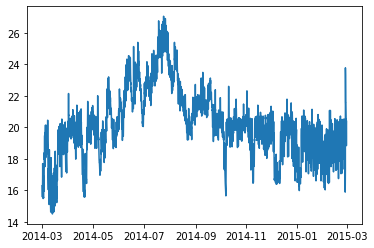

In [4]:
umt = UnivariateMultiTransformer(path='Air temperature.csv')
umt.set_month_range()

In [5]:
umt.train_test_split(train_percent=.8)
umt.scale()
umt.save_scaler()

Scaler has been saved to scaler.pkl


In [6]:
# convert data to classification problem

x_train_sc, y_train_sc = umt.transform(data_type='train', n_in=24, n_out=24)
x_test_sc, y_test_sc = umt.transform(data_type='test', n_in=24, n_out=24)

X shape: (1720, 24)
y shape: (1720, 24)
X shape: (394, 24)
y shape: (394, 24)


In [7]:
# reshape arrays for the model input

x_train_sc, x_test_sc = umt.model_input_reshape(x1=x_train_sc, x2=x_test_sc)

x1 new shape: (1720, 24, 1)
x2 new shape: (394, 24, 1)


In [9]:
steps = x_train_sc.shape[1]
features = x_train_sc.shape[2]
outputs = y_train_sc.shape[1]

In [10]:
# PART 2. Model

In [11]:
# read configs
with open('config.json') as conf:
    configs = json.load(conf)
lstm_configs = LSTMConfig(configs["LSTM"])

lstm_configs.loss

'mse'

In [12]:
# Better code organization, but ISSUES WITH serializing to H5f format!!!

class ProtoModel(Model):
    
    def __init__(self):
        super(ProtoModel, self).__init__()
        
        self.lstm_1 = LSTM(lstm_configs.layers['1']['n_neurons'], 
                         activation=lstm_configs.layers['1']["activation"], 
                        input_shape=(lstm_configs.layers['1']['input_shape']["timesteps"],
                                    lstm_configs.layers['1']['input_shape']["features"]),
                        return_sequences=True)
        '''
        self.lstm_2 = LSTM(lstm_configs.layers['2']["n_neurons"], 
                         activation=lstm_configs.layers['2']["activation"], 
                           dropout=lstm_configs.layers['2']["dropout"])
        '''
        
        self.dense = Dense(lstm_configs.layers['2']["n_neurons"])
    
    def call(self, inputs, training=True):
        x = self.lstm_1(inputs)
        x = self.lstm_2(x)
        
        return self.dense(x)

In [13]:
# our straightforward simple model

inputs = Input(shape=(lstm_configs.layers['1']['input_shape']["timesteps"], 
                      lstm_configs.layers['1']['input_shape']["features"]))

x = LSTM(lstm_configs.layers['1']['n_neurons'], 
         activation=lstm_configs.layers['1']["activation"],
         input_shape=(lstm_configs.layers['1']['input_shape']["timesteps"],
                                    lstm_configs.layers['1']['input_shape']["features"]))(inputs)

outputs = Dense(lstm_configs.layers['2']["n_neurons"])(x)
model = Model(inputs=inputs, outputs=outputs)

In [14]:
# model training

model.compile(loss=lstm_configs.loss, optimizer=lstm_configs.optimizer)

h = model.fit(x_train_sc, y_train_sc, epochs=lstm_configs.epochs, 
              batch_size=lstm_configs.batch_size, verbose=lstm_configs.verbose, 
              validation_data=(x_test_sc, y_test_sc), shuffle=False)

Epoch 1/30
54/54 [==============================] - 2s 28ms/step - loss: 0.0913 - val_loss: 0.0068
Epoch 2/30
54/54 [==============================] - 1s 25ms/step - loss: 0.0086 - val_loss: 0.0103
Epoch 3/30
54/54 [==============================] - 1s 24ms/step - loss: 0.0069 - val_loss: 0.0088
Epoch 4/30
54/54 [==============================] - 1s 24ms/step - loss: 0.0067 - val_loss: 0.0089
Epoch 5/30
54/54 [==============================] - 1s 24ms/step - loss: 0.0066 - val_loss: 0.0080
Epoch 6/30
54/54 [==============================] - 1s 24ms/step - loss: 0.0063 - val_loss: 0.0073
Epoch 7/30
54/54 [==============================] - 1s 24ms/step - loss: 0.0059 - val_loss: 0.0045
Epoch 8/30
54/54 [==============================] - 1s 25ms/step - loss: 0.0065 - val_loss: 0.0084
Epoch 9/30
54/54 [==============================] - 1s 26ms/step - loss: 0.0058 - val_loss: 0.0042
Epoch 10/30
54/54 [==============================] - 1s 26ms/step - loss: 0.0047 - val_loss: 0.0028
Epoch 11/

In [15]:
# Get the predicted values
predictions = model.predict(x_test_sc)

# test predictions
predictions_unscaled = umt.scaler.inverse_transform(predictions)
y_unscaled = umt.scaler.inverse_transform(y_test_sc)

# Get the root mean squarred error (RMSE) and the meadian error (ME)
rmse = np.sqrt(np.mean(predictions_unscaled - y_unscaled) ** 2)
me = np.median(y_unscaled - predictions_unscaled)
print("me: " + str(round(me, 4)) + ", rmse: " + str(round(rmse, 4)))

me: -0.15, rmse: 0.145


In [16]:
predictions[0]

array([0.43739423, 0.44836727, 0.44546962, 0.44409642, 0.4276892 ,
       0.41273788, 0.40171093, 0.37491858, 0.36222342, 0.34910166,
       0.33243144, 0.3191859 , 0.32310182, 0.3080692 , 0.31035283,
       0.3145861 , 0.31932452, 0.32958937, 0.34683177, 0.351127  ,
       0.36392564, 0.38213277, 0.39757013, 0.40301082], dtype=float32)

In [17]:
# saving test numpy array

with open('test.npy', 'wb') as f:
    np.save(f, x_test_sc)

In [18]:
# saving the model
model.save('model.h5')

In [20]:
with open('prediction.npy', 'wb') as f:
    np.save(f, predictions)

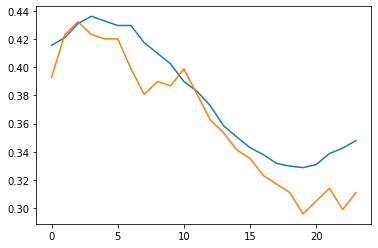

In [25]:
# plot scaled predictions vs actual

plt.plot(predictions[21])
plt.plot(y_test_sc[21])

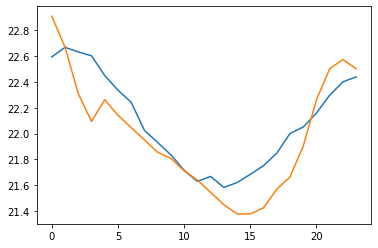

In [22]:
# plot predictions vs actual

plt.plot(predictions_unscaled[1])
plt.plot(y_unscaled[1])

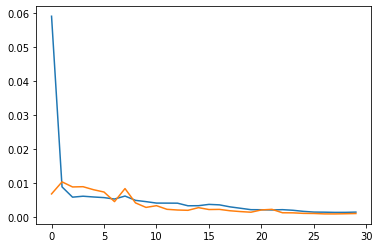

In [23]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])